<a href="https://colab.research.google.com/github/AdaobiNwafor/Coursera_Capstone_/blob/main/Finding_the_best_neighbourhood_in_North_York.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geocoder
!pip install folium
print('modules imported')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import geocoder
import requests
import json
import xml

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup

pd.set_option('display.max.rows', None)
pd.set_option('display.max.columns', None)

print('All modules imported')

All modules imported


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Geospatial_Coordinates.csv to Geospatial_Coordinates.csv


In [ ]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

contents = []
table = soup.find("table")
for row in table.findAll('td'):
  cell = {}
  if row.span.text == 'Not assigned':
    pass
  else:
      cell['PostalCode'] = row.p.text[:3]
      cell['Borough'] = (row.span.text).split('(')[0]
      cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
      contents.append(cell)


df = pd.DataFrame(contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


## Creating the data frame for Canada (toronto)

In [ ]:
coord1 = pd.read_csv('Geospatial_Coordinates.csv')   
coord = coord1[['Latitude', 'Longitude']]
Canada = pd.concat([df, coord], axis=1)
Canada.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.806686,-79.194353
1,M4A,North York,Victoria Village,43.784535,-79.160497
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.763573,-79.188711
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.770992,-79.216917
4,M7A,Queen's Park,Ontario Provincial Government,43.773136,-79.239476


### The borough of focus is 'North York'


In [ ]:
address = 'North York, Toronto'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York are 43.7543263, -79.44911696639593.


### Plotting the map of North York

In [ ]:
north_york = Canada[Canada['Borough'] == 'North York'].reset_index(drop=True)

map_nyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(north_york['Latitude'], north_york['Longitude'], north_york['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyork)  
    
map_nyork

In [ ]:
map_nyork = folium.Map(location=[latitude, longitude], zoom_start=10)

address = 'North York,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_n1, longitude_n1))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7543263, -79.44911696639593.


### Using the foursquare api

In [ ]:
CLIENT_ID = 'LVINK2Q5O52GAXXQ3SN3RSCQSIXL4KUIV0CSVFTC4RNBWF1C' # your Foursquare ID
CLIENT_SECRET = 'NRSECBZA2BFXIZGOWP0REIAF3VD4HQZ0MVAGCIES1ZQJVMVE' # your Foursquare Secret
VERSION = '20210621' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LVINK2Q5O52GAXXQ3SN3RSCQSIXL4KUIV0CSVFTC4RNBWF1C
CLIENT_SECRET:NRSECBZA2BFXIZGOWP0REIAF3VD4HQZ0MVAGCIES1ZQJVMVE


In [ ]:
radius = 1000
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
    longitude_n1, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [ ]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id',
       'venue.location.neighborhood'],
      dtype='object')

### Creating a function to get the category type

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Best for Bride,Bridal Shop,43.755789,-79.437834
1,Le Montmartre,French Restaurant,43.751219,-79.457446
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,TD Canada Trust,Bank,43.756232,-79.439025
4,Dairy Queen,Ice Cream Shop,43.755680,-79.440166
5,Subway,Sandwich Place,43.755741,-79.440502
6,RBC Royal Bank,Bank,43.755698,-79.438183
7,Petro-Canada,Gas Station,43.755112,-79.438838
8,Pizza Pizza,Pizza Place,43.755311,-79.441126
9,Times Square Diner,American Restaurant,43.751058,-79.455591


#### The number of different types of venues around North York

In [ ]:
a = pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Coffee Shop            4
Park                   3
Pizza Place            3
Bank                   2
Gas Station            2
Ice Cream Shop         1
Gift Shop              1
Shopping Mall          1
American Restaurant    1
French Restaurant      1
Name: categories, dtype: int64

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
  venues_list = []
  for name, lat, lng, in zip(names, latitudes, longitudes):
    print(name)

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    venue_results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in venue_results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    return(nearby_venues)
  

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Nearby Venues around North York

In [ ]:
# The nearby venues

NYork_venues = getNearbyVenues(names=north_york['Neighborhood'],
                               latitudes = north_york['Latitude'],
                               longitudes = north_york['Longitude'])

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills North
Glencairn
Don Mills South
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview East
York Mills, Silver Hills
Downsview West
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview Central
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale South
Downsview Northwest
York Mills West
Willowdale West


In [ ]:
print('There are {} Uniques Categories.'.format(len(NYork_venues['Venue Category'].unique())))

There are 211 Uniques Categories.


In [ ]:
NYork_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",29,29,29,29,29,29
Bayview Village,43,43,43,43,43,43
"Bedford Park, Lawrence Manor East",100,100,100,100,100,100
Don Mills North,28,28,28,28,28,28
Don Mills South,38,38,38,38,38,38


#### Using dummies to create all the different columns

In [ ]:
NYork_onehot = pd.get_dummies(NYork_venues[['Venue Category']], prefix="", prefix_sep="")

NYork_onehot['Neighborhood'] = NYork_venues['Neighborhood']

fixed_columns = [NYork_onehot.columns[-1]] + list(NYork_onehot.columns[:-1])
NYork_onehot = NYork_onehot[fixed_columns]
NYork_grouped = NYork_onehot.groupby('Neighborhood').mean().reset_index()
NYork_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Noodle House,Office,Opera House,Organic Grocery,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Ski Chalet,Snack Place,Soccer Field,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Finding the top 10 venues in each neighborhood

In [ ]:
num_top_venues = 10
for hood in NYork_grouped['Neighborhood']:
  print('------'+hood+'------')
  temp = NYork_grouped[NYork_grouped['Neighborhood'] == hood].T.reset_index()
  temp.columns = ['venues', 'freq']
  temp = temp.iloc[1:]
  temp['freq'] = temp['freq'].astype(float)
  temp = temp.round({'freq': 2})
  print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
  print('\n')

------Bathurst Manor, Wilson Heights, Downsview North------
                      venues  freq
0                       Bank  0.07
1                Pizza Place  0.07
2                       Park  0.07
3                Coffee Shop  0.07
4          Convenience Store  0.03
5              Shopping Mall  0.03
6  Middle Eastern Restaurant  0.03
7         Frozen Yogurt Shop  0.03
8        Fried Chicken Joint  0.03
9                 Ski Chalet  0.03


------Bayview Village------
               venues  freq
0         Coffee Shop  0.12
1       Grocery Store  0.07
2   Indian Restaurant  0.05
3             Brewery  0.05
4        Burger Joint  0.05
5      Sandwich Place  0.05
6  Turkish Restaurant  0.05
7         Supermarket  0.05
8   Afghan Restaurant  0.05
9         Pizza Place  0.05


------Bedford Park, Lawrence Manor East------
                venues  freq
0                 Café  0.08
1          Coffee Shop  0.08
2           Restaurant  0.07
3   Italian Restaurant  0.05
4             Beer Bar  

In [ ]:
def return_most_common_venues(row, num_top_venues):
  row_categories = row.iloc[1:]
  row_categories_sorted = row_categories.sort_values(ascending=False)

  return row_categories_sorted.index.values[0: num_top_venues]

#### Creating a dataframe of the top 10 venues in each neighborhood

In [ ]:
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
      try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
      except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NYork_grouped['Neighborhood']

for ind in np.arange(NYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NYork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Park,Coffee Shop,Pizza Place,Bank,Grocery Store,Restaurant,Ski Chalet,Shopping Mall,Sandwich Place,Bridal Shop
1,Bayview Village,Coffee Shop,Grocery Store,Supermarket,Burger Joint,Afghan Restaurant,Sandwich Place,Brewery,Turkish Restaurant,Indian Restaurant,Pizza Place
2,"Bedford Park, Lawrence Manor East",Café,Coffee Shop,Restaurant,Italian Restaurant,Beer Bar,Japanese Restaurant,Deli / Bodega,Seafood Restaurant,Bakery,Gym
3,Don Mills North,Coffee Shop,Intersection,Bus Line,Park,Bakery,Ice Cream Shop,General Entertainment,Fast Food Restaurant,Metro Station,Convenience Store
4,Don Mills South,Fast Food Restaurant,Coffee Shop,Pharmacy,Bank,Intersection,Pizza Place,Sandwich Place,Convenience Store,Noodle House,Discount Store


### Using K-Means to cluster

In [ ]:
# Using K-Means to cluster neighborhood into 3 clusters
NYork_grouped_clustering = NYork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NYork_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0,
       0, 0], dtype=int32)

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NYork_merged = north_york.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NYork_merged = NYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NYork_merged.head()# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.806686,-79.194353,0,Fast Food Restaurant,Trail,Bakery,Park,Gym,Chinese Restaurant,Caribbean Restaurant,Restaurant,Sandwich Place,Spa
1,M4A,North York,Victoria Village,43.784535,-79.160497,2,Italian Restaurant,Breakfast Spot,Playground,Park,Burger Joint,Discount Store,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.770992,-79.216917,1,Park,Coffee Shop,Pharmacy,Fast Food Restaurant,Mobile Phone Shop,Chinese Restaurant,Indian Restaurant,Diner,Escape Room,Electronics Store
3,M3B,North York,Don Mills North,43.711112,-79.284577,0,Coffee Shop,Intersection,Bus Line,Park,Bakery,Ice Cream Shop,General Entertainment,Fast Food Restaurant,Metro Station,Convenience Store
4,M6B,North York,Glencairn,43.757410,-79.273304,0,Electronics Store,Coffee Shop,Asian Restaurant,Restaurant,Pharmacy,Chinese Restaurant,Light Rail Station,Indian Restaurant,Fast Food Restaurant,Sandwich Place


In [ ]:
kclusters = 10

#### Creating a map that shows the clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude_n1, longitude_n1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NYork_merged['Latitude'], 
                                   NYork_merged['Longitude'], 
                                   NYork_merged['Neighborhood'], 
                                   NYork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [ ]:
df1=NYork_merged.loc[NYork_merged['Cluster Labels'] == 0,NYork_merged.columns[[2] + list(range(5, NYork_merged.shape[1]))]]
df2=NYork_merged.loc[NYork_merged['Cluster Labels'] == 1,NYork_merged.columns[[2] + list(range(5, NYork_merged.shape[1]))]]
df3=NYork_merged.loc[NYork_merged['Cluster Labels'] == 2,NYork_merged.columns[[2] + list(range(5, NYork_merged.shape[1]))]]

### Plotting North York Average Housing Prices by Neighborhood

In [ ]:
NYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood": north_york["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0]})

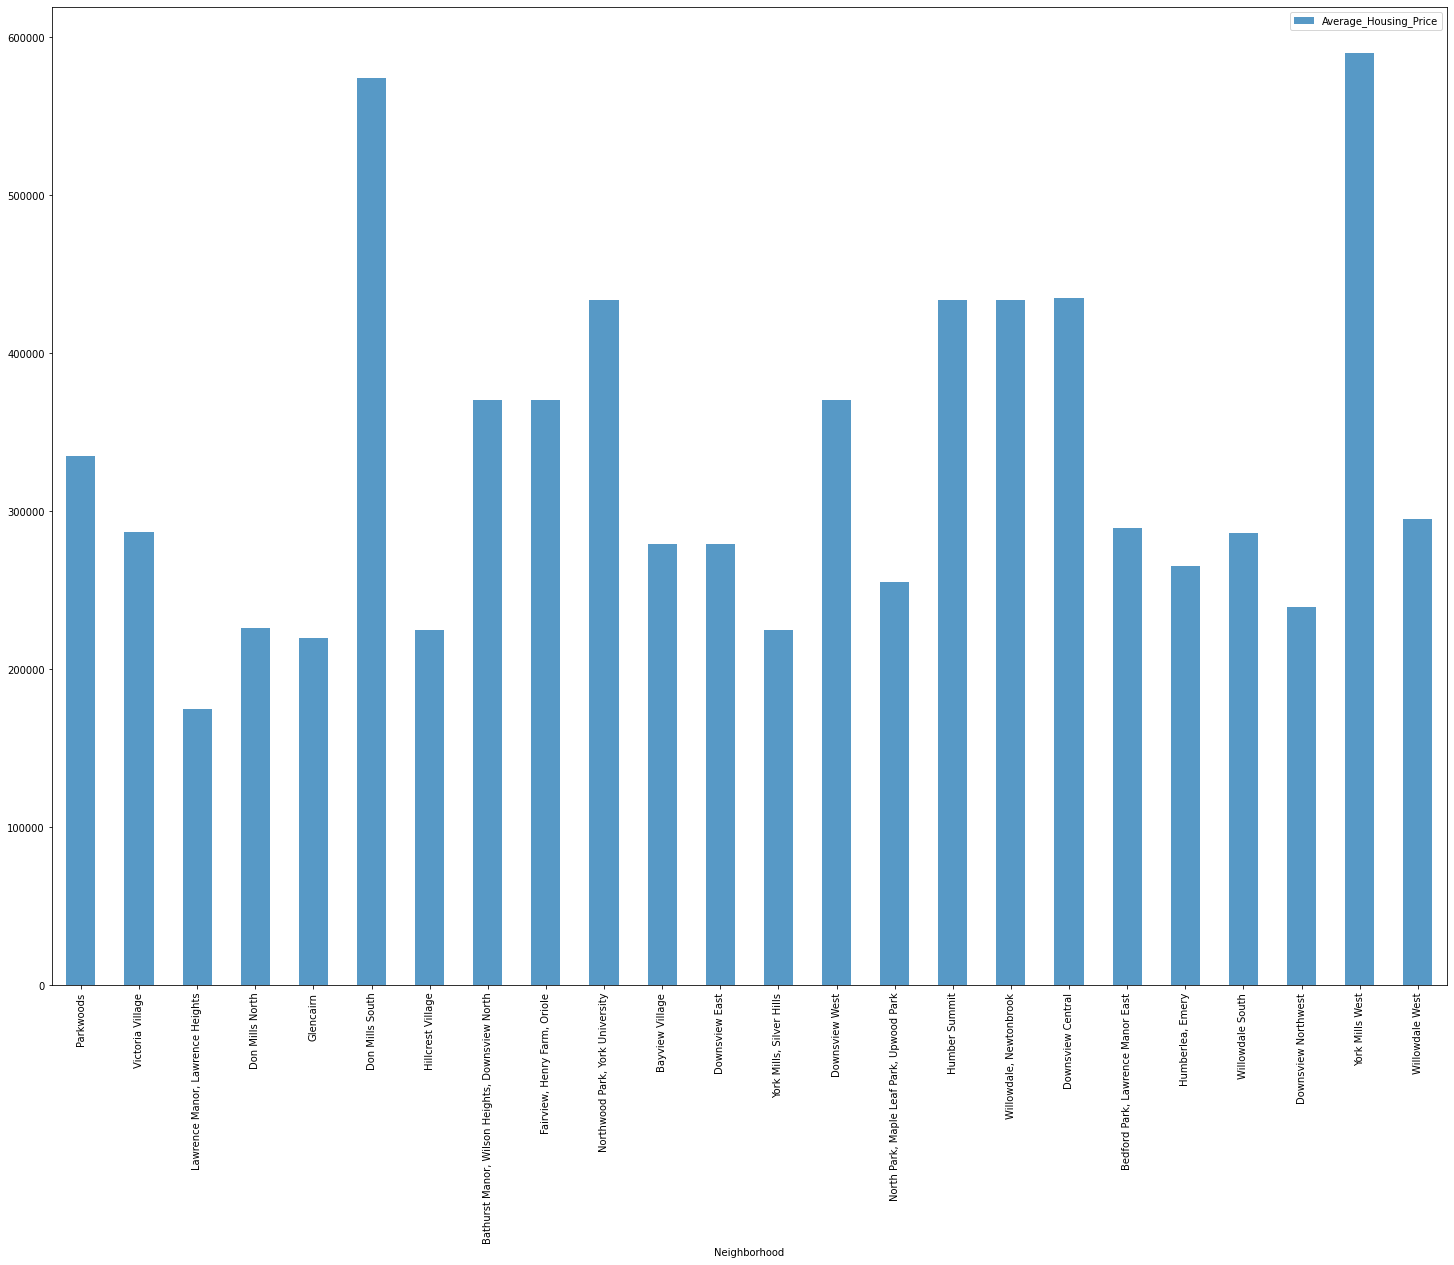

In [ ]:
NYork_Avg_HousingPrice.set_index('Neighborhood', inplace=True, drop=True)
NYork_Avg_HousingPrice.plot(kind='bar', figsize=(25, 18), alpha=0.75)
plt.savefig('avg_housing_price.png')

#### Plotting North York School Rating by Neighborhood

In [ ]:
clusters = pd.DataFrame({'Cluster1': df1['Neighborhood'],
                         'Cluster2': df2['Neighborhood'],
                         'Cluster3': df3['Neighborhood']
                         })
clusters = clusters.replace(np.nan, '', regex=True)

In [174]:
new_NYork = NYork_merged.set_index('Neighborhood', drop=True)

NYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

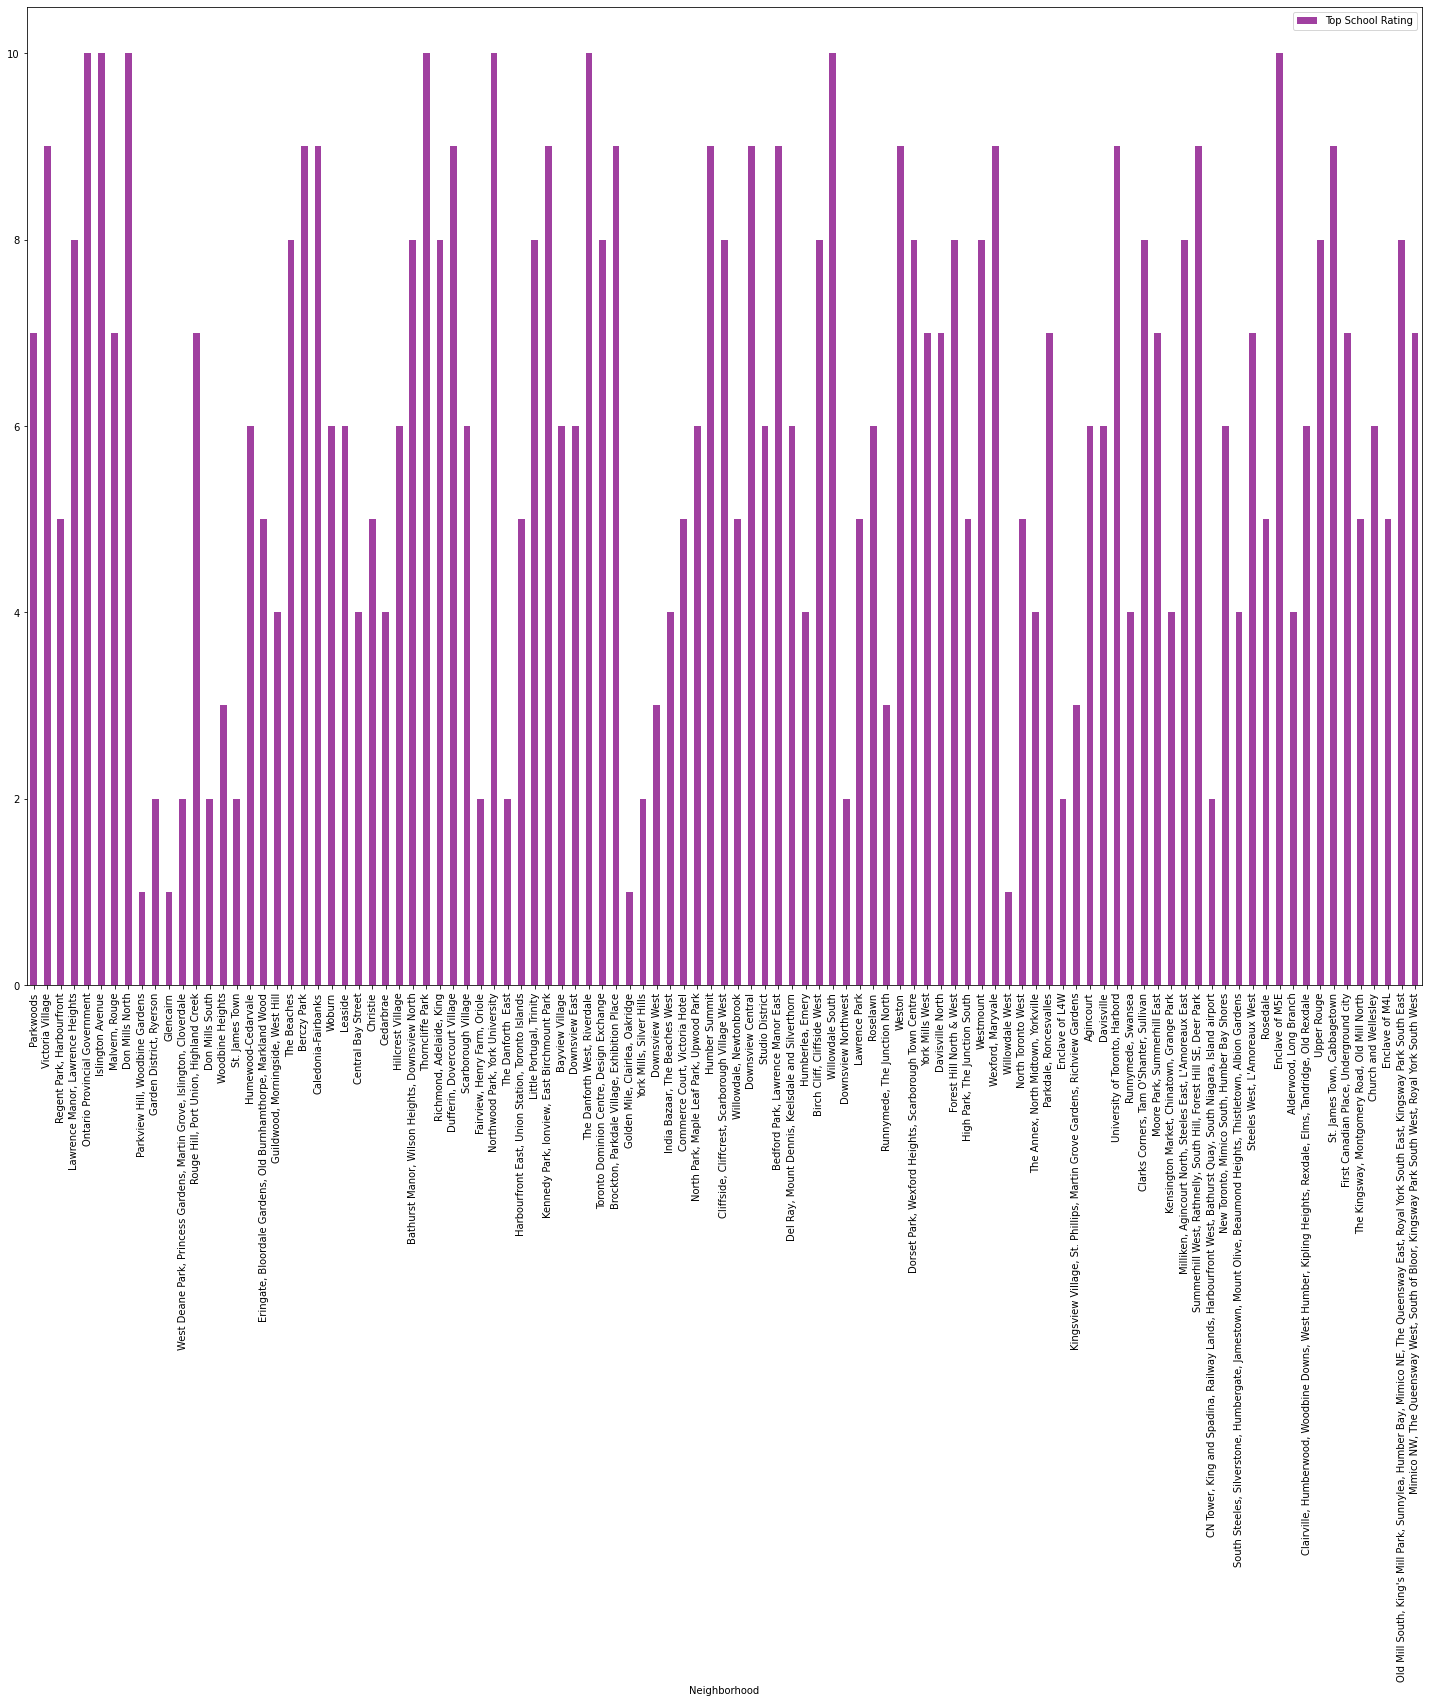

In [175]:
NYork_school_ratings.set_index('Neighborhood', inplace=True, drop=True)
c = NYork_school_ratings.plot(kind='bar', figsize=(25,18), color='purple', alpha=0.75)
c
plt.savefig('top_school_rating.png')